# fABBA Transform

Converts time series into symbolic representation of char or int. Two main processes are involved in this conversion :
1. Compression : Applies polynomial chain approximation to time series to convert it into pieces. 
                 These pieces are tuples of form (length, increment).

2. Digitization : These pieces are clustered based on different alogrithms. Each cluster is then assigned a label
                  which can be int or char based on alphabet_set hyperparameter.


## Univariate Example

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sktime.datasets import load_airline
from sktime.transformations.series.fabba import FABBA

# Load example dataset
y = load_airline()

# Load fABBA transformer
transformer = FABBA(
    n_jobs=1,
    # k=50, # doesn't matter for agg, since it determines k automatically
    random_state=42,
    return_start_values=True,  # neccessary for inverse transform
    method="agg",  # method for clustering
    tolerance=0.001,  # determines no of pieces formed, tolerance for approximation
    alpha=0.05,  # determines no of symbols formed, tolerance for clustering
)

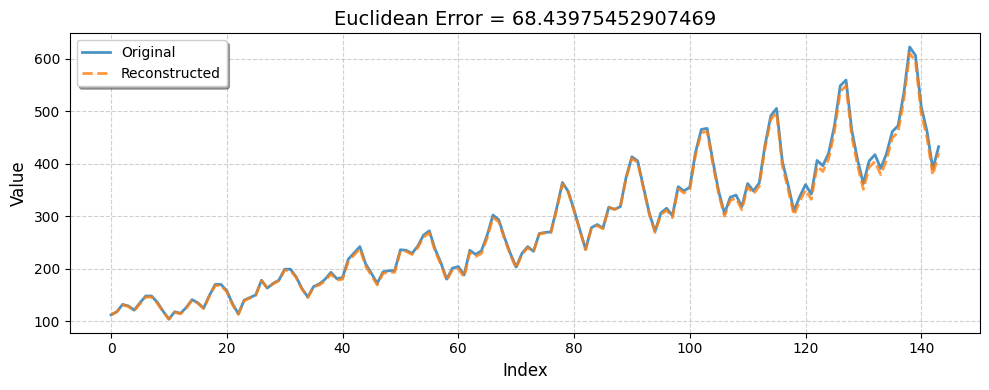

In [2]:
# Transform and inverse transform
y_transformed = transformer.fit_transform(y)
y_reconstructed = transformer.inverse_transform(y_transformed)


# Error metric to use to measure quality of reconstruction
def euclidean_error_uni(original, reconstructed):
    """Euclidean error between two series."""
    if isinstance(original, pd.Series):
        # if lengths differ due to quantization, cut to min length
        min_len = min(len(original), len(reconstructed))
        diff = (
            original.iloc[0:min_len].to_numpy().flatten()
            - reconstructed.iloc[0:min_len].to_numpy().flatten()
        )
        return np.linalg.norm(diff)


# Plot results
error = euclidean_error_uni(y, y_reconstructed)
plt.figure(figsize=(10, 4))
plt.plot(y.values, label="Original", linewidth=2, alpha=0.8)
plt.plot(y_reconstructed, label="Reconstructed", linestyle="--", linewidth=2, alpha=0.8)
plt.title(f"Euclidean Error = {error}", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(fontsize=10, frameon=True, shadow=True)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Multivariate Example

In [ ]:
import matplotlib.pyplot as plt

from sktime.datasets import load_arrow_head
from sktime.transformations.series.fabba import FABBA

# Load example dataset
y = load_arrow_head()

# Load fABBA transformer
transformer = FABBA(
    n_jobs=1,
    # k=50, # doesn't matter for agg, since it determines k automatically
    random_state=42,
    return_start_values=True,  # neccessary for inverse transform
    method="agg",  # method for clustering
    tolerance=0.001,  # determines no of pieces formed, tolerance for approximation
    alpha=0.05,  # determines no of symbols formed, tolerance for clustering
)

Average Euclidean Error = 0.5294147843046196


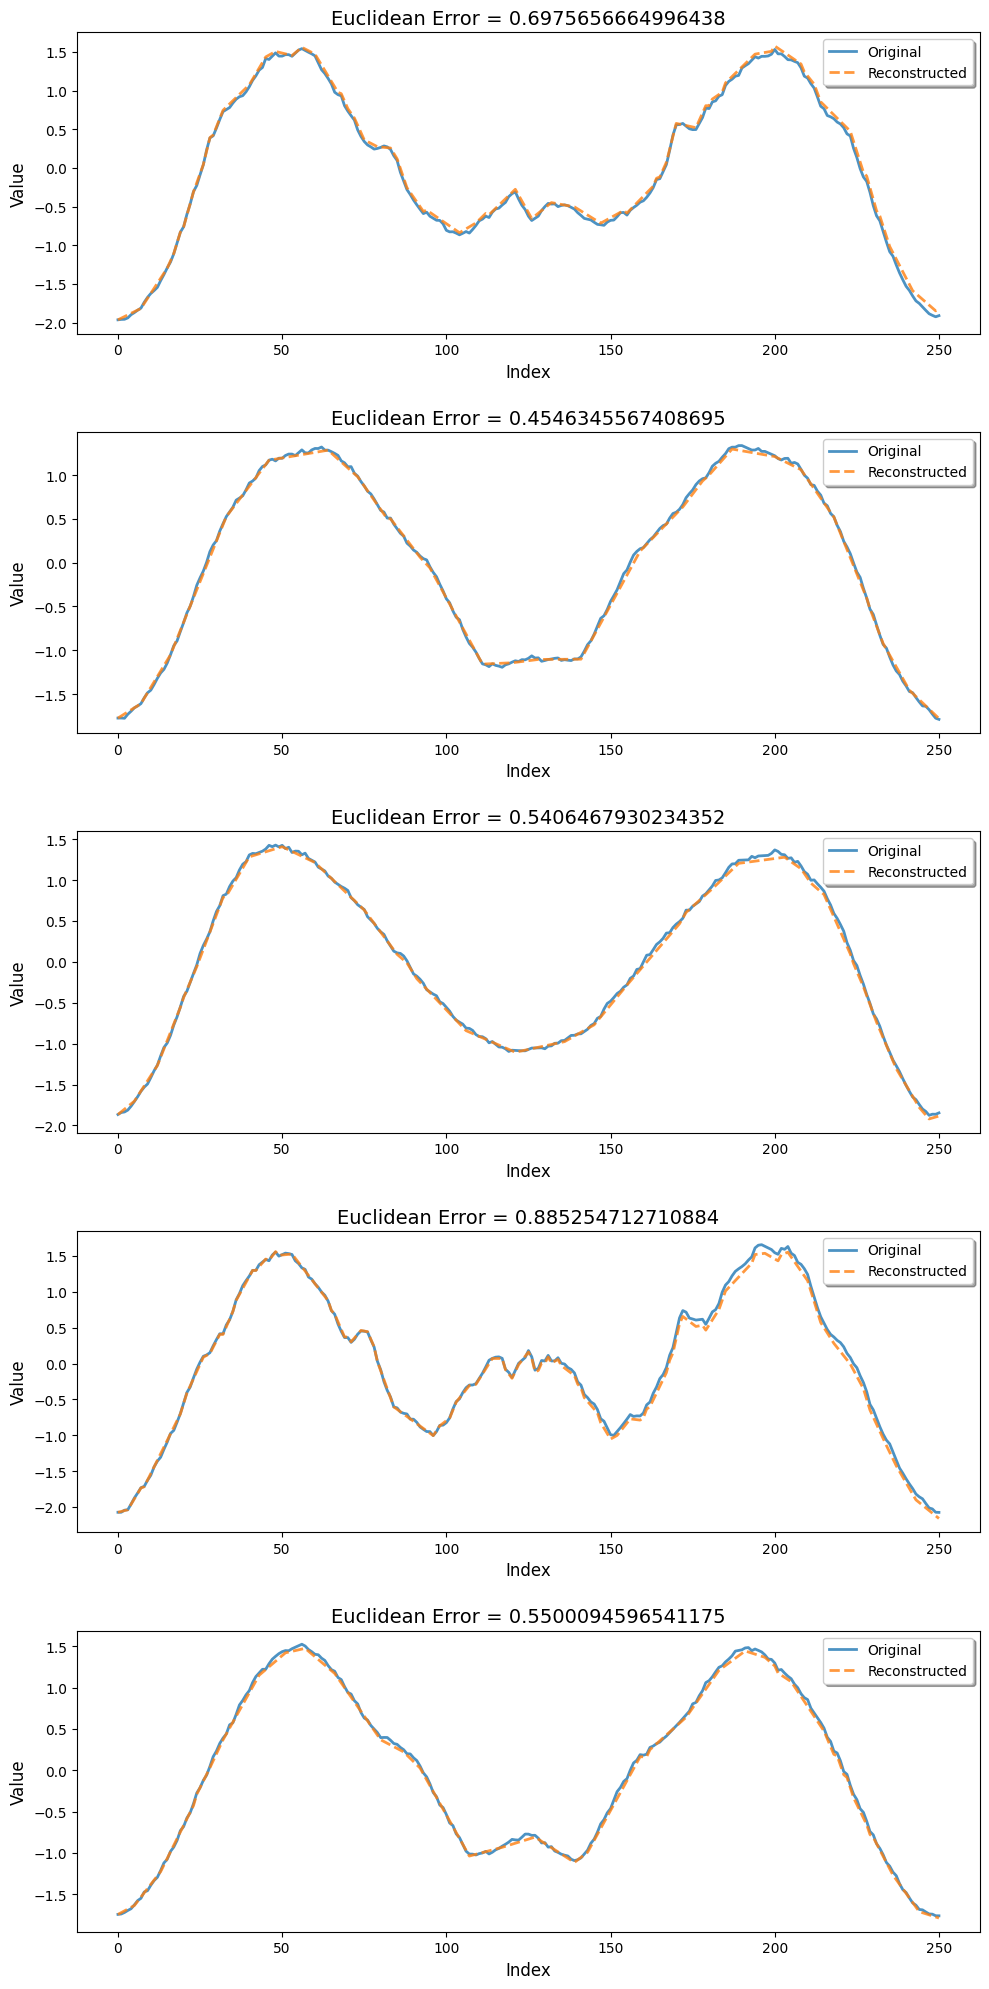

In [4]:
# Transform and inverse transform
y_transformed = transformer.fit_transform(y[0])
y_reconstructed = transformer.inverse_transform(y_transformed)

# Note that in y_transformed each symbol sequence produced for each time series,
# starts with the start value of that time series if return_start_values=True and
# the symbol sequence is padded with -1 (or '' if return_as_strings=True)
# to make all symbol sequences the same length. This is neccessary to pass some checks
# in sktime.


# Error metric to use to measure quality of reconstruction
def euclidean_error_multi(original, reconstructed):
    """Euclidean error between two series."""
    if isinstance(original, pd.DataFrame):
        error = 0
        for i in range(len(original)):
            # Get row values
            original_series = original.iloc[i]
            original_series = original_series.iloc[0].to_numpy().flatten()
            reconstructed_series = reconstructed.iloc[i]
            reconstructed_series = reconstructed_series.iloc[0].to_numpy().flatten()
            # if lengths differ due to quantization, cut to min length
            min_len = min(len(original_series), len(reconstructed_series))
            diff = original_series[0:min_len] - reconstructed_series[0:min_len]
            error += np.linalg.norm(diff)

        avg_error = error / len(original)
        return avg_error

    elif isinstance(original, pd.Series):
        # if lengths differ due to quantization, cut to min length
        min_len = min(len(original), len(reconstructed))
        diff = (
            original.iloc[0:min_len].to_numpy().flatten()
            - reconstructed.iloc[0:min_len].to_numpy().flatten()
        )
        return np.linalg.norm(diff)


# Plot results
error = euclidean_error_multi(y[0], y_reconstructed)
print(f"Average Euclidean Error = {error}")

# Plotting 5 time series
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
for row in range(5):
    original = y[0].iloc[row, 0]
    reconstructed = y_reconstructed.iloc[row, 0]
    axes[row].plot(original, label="Original", linewidth=2, alpha=0.8)
    axes[row].plot(
        reconstructed, label="Reconstructed", linestyle="--", linewidth=2, alpha=0.8
    )
    axes[row].set_title(
        f"Euclidean Error = {euclidean_error_multi(original, reconstructed)}",
        fontsize=14,
    )
    axes[row].set_xlabel("Index", fontsize=12)
    axes[row].set_ylabel("Value", fontsize=12)
    axes[row].legend(fontsize=10, frameon=True, shadow=True)

plt.tight_layout(h_pad=2.0)
plt.show()